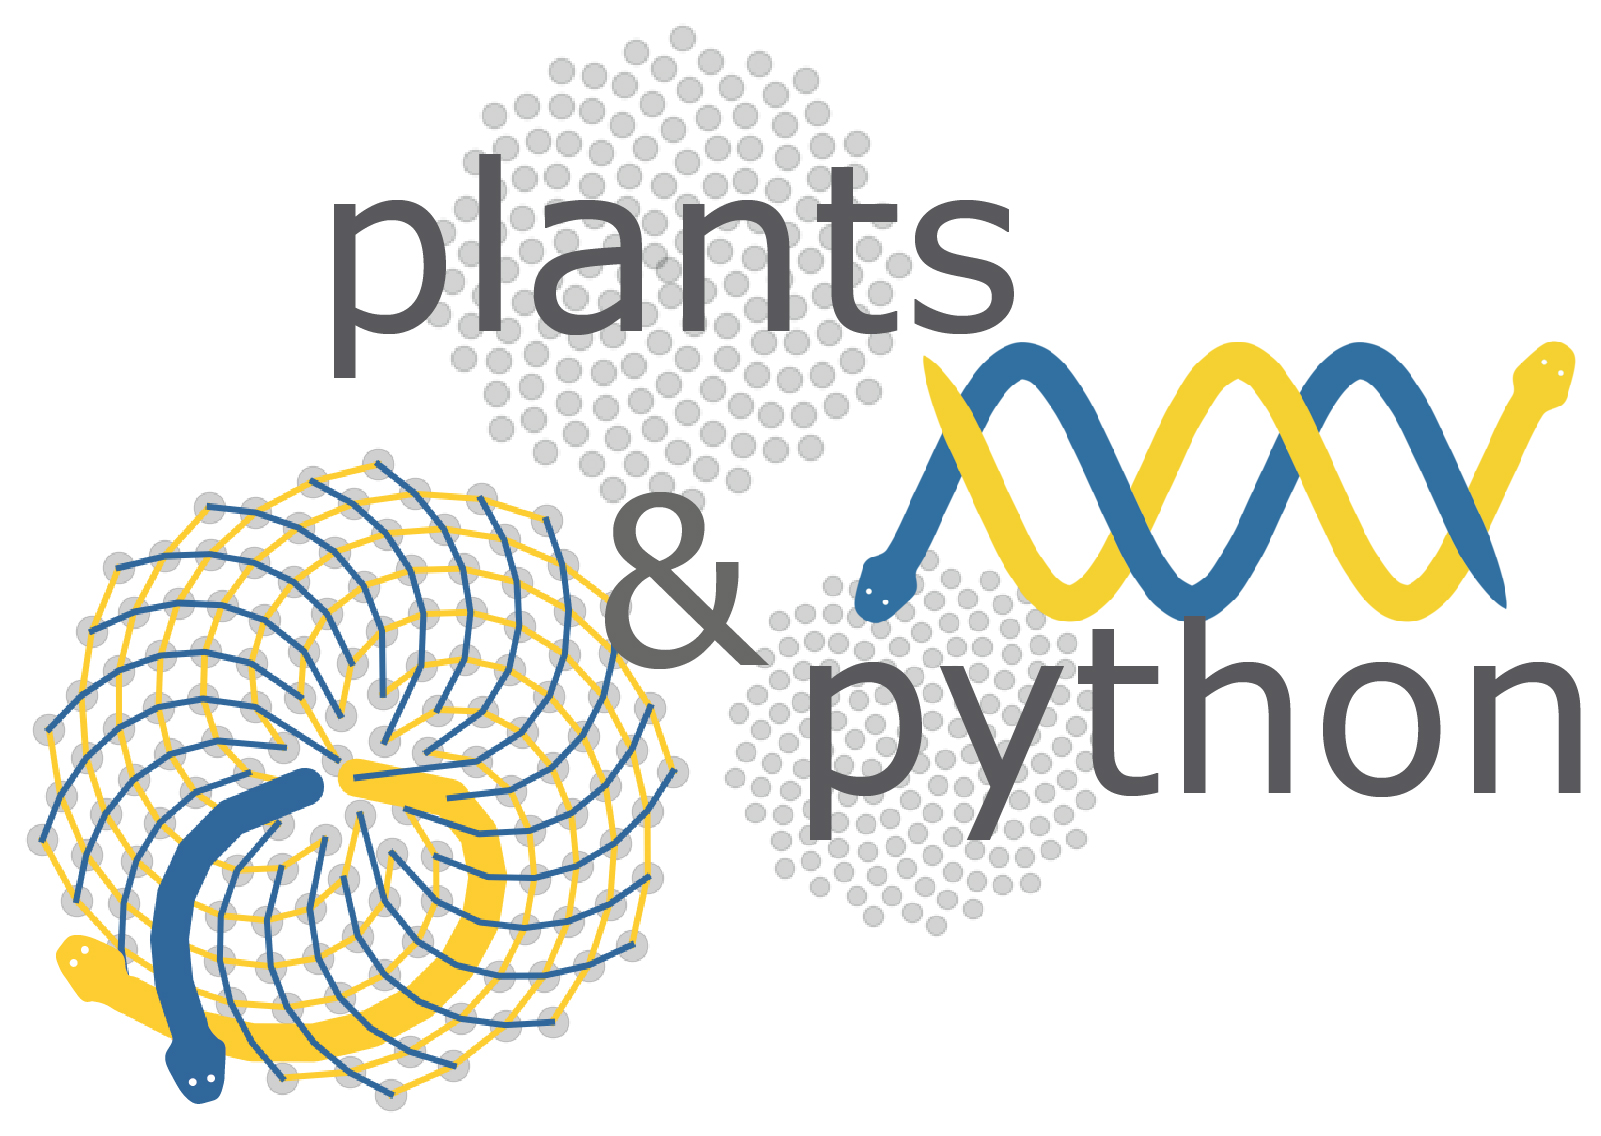

# Practice: How to Build a Genome

In this exercise, we will use Wtdbg2, a relatively new genome assembler that runs ~10 fold faster than the leading assemblers FALCON and CANU. This will allow us to assemble a high-quality genome in just a few minutes. Wtdbg2 is a _de novo_ sequence assembler for long noisy reads produced by PacBio or Oxford Nanopore Technologies. It assembles raw reads without error correction and then builds the consensus from intermediate assembly output. Wtdbg2 is able to assemble the human and even the 32Gb Axolotl genome at a speed tens of times faster than CANU and FALCON while producing contigs of comparable base accuracy.

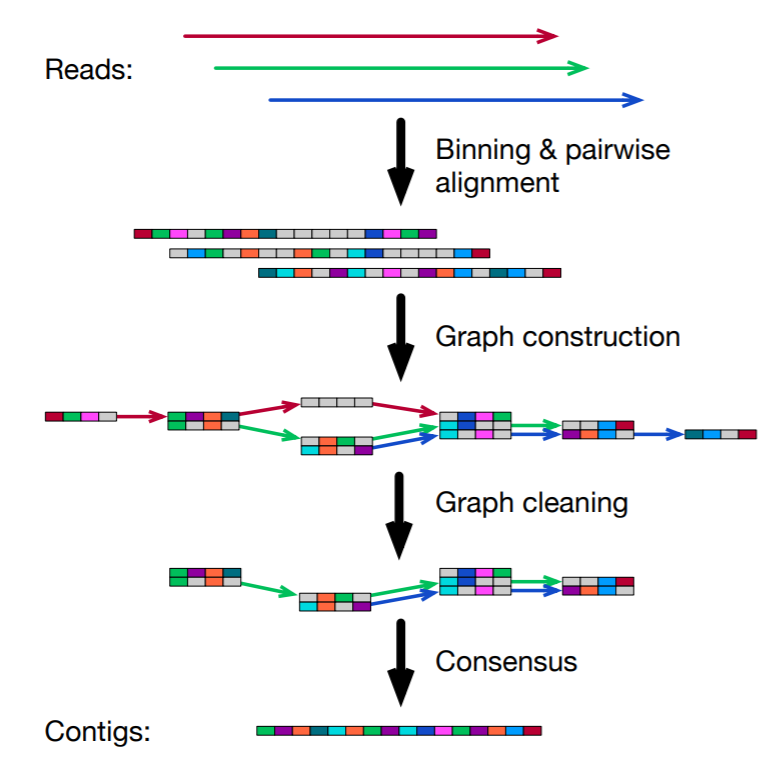

During assembly, wtdbg2 chops reads into 1024bp segments, merges similar segments into a vertex and connects vertices based on the segment adjacency on reads. The resulting graph is called fuzzy Bruijn graph (FBG). It is akin to De Bruijn graph but permits mismatches/gaps and keeps read paths when collapsing k-mers. The use of FBG distinguishes wtdbg2 from the majority of long-read assemblers.

I have installed wtdbg2 on HPCC under the research space for our course: 
`/mnt/research/HRT841_F21/programs/wtdbg2/`

If we run `/mnt/research/HRT841_F21/programs/wtdbg2/wtdbg2 --help` in terminal we get the following info: 

    WTDBG: De novo assembler for long noisy sequences
    Author: Jue Ruan <ruanjue@gmail.com>
    Version: 2.5 (20190621)
    Usage: wtdbg2 [options] -i <reads.fa> -o <prefix> [reads.fa ...]
    Options:
     -i <string> Long reads sequences file (REQUIRED; can be multiple), []
     -o <string> Prefix of output files (REQUIRED), []
     -t <int>    Number of threads, 0 for all cores, [4]
     -f          Force to overwrite output files
     -x <string> Presets, comma delimited, []
            preset1/rsII/rs: -p 21 -S 4 -s 0.05 -L 5000
                        preset2: -p 0 -k 15 -AS 2 -s 0.05 -L 5000
                        preset3: -p 19 -AS 2 -s 0.05 -L 5000
                  sequel/sq
               nanopore/ont:
            (genome size < 1G: preset2) -p 0 -k 15 -AS 2 -s 0.05 -L 5000
            (genome size >= 1G: preset3) -p 19 -AS 2 -s 0.05 -L 5000
          preset4/corrected/ccs: -p 21 -k 0 -AS 4 -K 0.05 -s 0.5
     -g <number> Approximate genome size (k/m/g suffix allowed) [0]
     -X <float>  Choose the best <float> depth from input reads(effective with -g) [50.0]
     -L <int>    Choose the longest subread and drop reads shorter than <int> (5000 recommended for PacBio) [0]
                 Negative integer indicate tidying read names too, e.g. -5000.
     -k <int>    Kmer fsize, 0 <= k <= 23, [0]
     -p <int>    Kmer psize, 0 <= p <= 23, [21]
                 k + p <= 25, seed is <k-mer>+<p-homopolymer-compressed>
     -K <float>  Filter high frequency kmers, maybe repetitive, [1000.05]
                 >= 1000 and indexing >= (1 - 0.05) * total_kmers_count
     -S <float>  Subsampling kmers, 1/(<-S>) kmers are indexed, [4.00]
                 -S is very useful in saving memeory and speeding up
                 please note that subsampling kmers will have less matched length
     -l <float>  Min length of alignment, [2048]
     -m <float>  Min matched length by kmer matching, [200]
     -R          Enable realignment mode
     -A          Keep contained reads during alignment
     -s <float>  Min similarity, calculated by kmer matched length / aligned length, [0.05]
     -e <int>    Min read depth of a valid edge, [3]
     -q          Quiet
     -v          Verbose (can be multiple)
     -V          Print version information and then exit
     --help      Show more options`


There is a lot to unpack here, but for our first assembly, we only need to set a few parameters and provide a few input files: <br>
`-i` this is the file containing the raw long read sequences. For all of our unknown genomes, we will be using raw PacBio reads. These will be located under `/mnt/research/HRT841_F21/Genome_assembly/Unknown_sequences/` <br>
Each set of raw PacBio sequences will have the prefix: `Unknown_PacBio_HiFiX.fasta` and each file represents sequence reads from a different plant species. There are 6 unknown sets of samples and you should assemble the sample corresponding to your group number. <br>
<br>
`-o` Sets the output prefix and directory of where the assembly files will go. We can set this to two places: your home directory `/mnt/home/MSU_net_ID` or `/mnt/scratch/MSU_net_ID`. Putting files in /scratch is preferable since you have _virtually_ unlimited space. The downside is files are automatically removed from /scratch after 45 days, so any important files you want to keep should be removed before then. Do not write to the /HRT841_F21 reasearch space! <br>
<br>
`-t` Sets the number of threads or processors to use. Using more processors speeds up the job somewhat (but not always) proportionally, but jobs requesting more processors tend to take longer to launch in the queuing system. We will shoot for 8-12 in this case. <br>
<br>
`-x` Sets presets for graph construction and read utilization based on the seuqencing technology that was used (PacBio or Nanopore). Our data will be relatively old (~2-3 year) PacBio data, so we will set it as `-x rs`<br>
<br>
`-g` Sets the approximate genome size of the organism. Our unknown species will have relatively small genomes ranging from 14-50 Mb, so we can set it as  20 megabases or `-g 20m`<br>
<br>
We will leave all other parameters as default, but these can be optimized. 

Because wtdbg2 has low memory and CPU requirements, and we're assembling relatively small genomes, we can run this job on a developmental node. But, it is probably better to submit a job to the compute nodes via SLURM. I will provide examples for both. <br> <br>

**Running an assembly on a developmental node:** There are several ways to access a developmental node from the head node, but the simplest is to use the HPCC module `powertools` to randomly assign us to a node without too many processes running. <br>
First, we need to load the module `powertools` as follows. Powertools has lots of useful utilities, but we will use `dev`

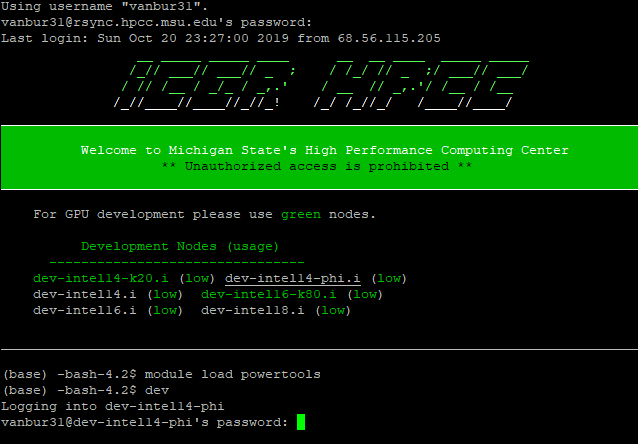

This will log us into a developmental node to run wtdbg2. 

We can run the following example command to launch the assembly on a developmental node on hpcc. **Note: remember to change the directories to your correct path, change the sequence files to correspomnd with your group number, and change the output directory accordingly:**<br>
<br>
`/mnt/research/HRT841_F21/programs/wtdbg2/wtdbg2 -x rs -g 500m -i /mnt/research/HRT841_F21/Genome_assembly/Unknown_sequences/Unknown_PacBioHifi_01.fastq -o /mnt/scratch/vanbur31/test_assemblies/wtdbg2_unknown_1 -t 8`

Now that the assembly has finished, we need to turn the contig layout into actual sequences. We do this using `./wtpoa-cns` with the following command: 
<br>
`/mnt/research/HRT841_F21/programs/wtdbg2/wtpoa-cns -i /mnt/scratch/vanbur31/test.ctg.lay.gz -fo /mnt/scratch/vanbur31/Unknown_assembly_01.fasta`

Where:
<br>
`-i` Sets the path for the inmput contig layout file showing how contigs are arranged in the assembly graph. <br>
<br>
`-t` Sets the number of threads or processors to use. Again, using more processors speeds up the job somewhat (but not always) proportionally, but jobs requesting more processors tend to take longer to launch in the queuing system. We will shoot for 12 in this case. <br>
<br>
`-fo` Sets the output path of the final assembly file. This is the file we ultimately care about. <br>



**Sumbitting an assembly job to SLURM:** We learned how to submit a job to the queue using SLURM in the pre-class lesson. Below is an example SLURM submission script for running the assembly on the compute nodes at HPCC. You can copy this file, edit it in your favorite text editor, save it as assembly.sb in an appropriate directory on hpcc, and submit it to SLURM for scheduling. I would recommend saving this file to the same directory you will run the assembly in. It may take a few hours for this to run, and it may not finish until the next day. This is OK, and you can proceed to the lesson on BioPython in the meantime. <br>
**Note: Remember to change the directories, file names, and output file names before submitting the job to SLURM.**
<br>
`#!/bin/bash --login
########## SBATCH Lines for Resource Request ##########
 
#SBATCH --time=24:00:00             # limit of wall clock time - how long the job will run (same as -t)
#SBATCH --nodes=1                 # number of different nodes - could be an exact number or a range of nodes (same as -N)
#SBATCH --ntasks=8                 # number of tasks - how many tasks (nodes) that you require (same as -n)
#SBATCH --cpus-per-task=1           # number of CPUs (or cores) per task (same as -c)
#SBATCH --mem-per-cpu=4g            # memory required per allocated CPU (or core) - amount of memory (in bytes)
#SBATCH --job-name wtdbg2      # you can give your job a name for easier identification (same as -J)
 
########## Command Lines to Run ##########

cd /mnt/scratch/vanbur31/test_assemblies/ # change directories to where you want the assembly files to be output
/mnt/research/HRT841_F21/programs/wtdbg2/wtdbg2 -x rs -g 500m -i /mnt/research/HRT841_F21/Genome_assembly/Unknown_sequences/Unknown_PacBioHifi_01.fastq -o /mnt/scratch/vanbur31/test_assemblies/wtdbg2_unknown_1 -t 8 # Command to be run
/mnt/research/HRT841_F21/programs/wtdbg2/wtpoa-cns -i /mnt/scratch/vanbur31/test.ctg.lay.gz -fo /mnt/scratch/vanbur31/Unknown_assembly_01.fasta`
<br>

This submission script might be wrapped oddly in Jupyter, you can see an example SLURM script for running wtdbg2 under: `/mnt/research/HRT841_F21/Slurm_example_scripts/wtdbg2_slurm_example.sb` <br>
To submit our request, we simply use the command `sbatch` while on a developmental node, and call the above submission script (which I have named `wtdbg2_slurm_example.sb`. Remember, you either need to be in the same directory as the submission script or, you can provide the full file path. 
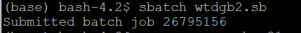
This job has been given the ID 26795156, and will be run as soon as resources become available on hpcc. How will we know if the job is running? We can use the command `squeue` to see when the job is scheduled to run. You can do this on a job by job basis by providing the job ID or you can use the flag `-u` with your MSU netID to see all of the jobs you have currently in the queue:
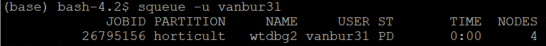
<br>
It may take a while for the assembly to run, but you can check the progress by opening the slurm output log. In the meantime, you can work in groups learning about importing, processing, and analyzing sequences using the Python package Biopython.

## Putting it all together

Now that we have our genome, it’s time to figure out what it is! Although, ideally you would know the species before you sequenced it... There are circumstances where you might not know the species though, such as microbiome metagenomics, pathology, forensics, etc. 
<br>
There are several ways to do this, but the simplest is to align our sequences against a database of known sequences and return the best matches. There are  several tools that can do this and for simplicity, we will use BLAST. We will explore tools that can handle genome-scale alignments in later notebooks. For this exercise you will need to import the assembly (after downloading it to your local computer from HPCC), pull out a single or a few contigs, and use BLAST to figure out what species was sequenced. A few things to keep in mind: <br> <br>
(1) The time it takes to run BLAST over the internet depends on the size and number of querie sequences. Create a single sequence record using Biopython and maybe even break the large contigs into multiple smaller fragments for BLAST. <br> <br>
(2) A plant genome can be quite large (100-10,000 Gb in general), so you might not want to download the whole assembly to your local computer. You can use some UNIX commands to break up the output fasta file before downloading it. 

In [6]:
## Answer

## Use SeqIO.parse to import your sequence file

from Bio import SeqIO

SeqIO.parse("sequences.txt", "fasta")



In [11]:
## Use SeqIO.to_dict to create a dictionary to filter out a single record (contig) from the fasta file
grass_dict = SeqIO.to_dict(SeqIO.parse("sequences.txt", "fasta"))
seq_record = grass_dict["Ot_Chr10_26045"]

## Use SeqIO.write to write the single fasta sequence to a new file
SeqIO.write(seq_record, "unknown1.fa", "fasta")

# Use SeqIO.read to read in the single entry fasta file

query = SeqIO.read("unknown1.fa", format="fasta")


# Use NCBIWWW.qblast to run a BLAST on your unknown sequence
from Bio.Blast import NCBIWWW
result_handle = NCBIWWW.qblast("blastn", "nt", query.seq, format_type="Text")
with open("my_blast.txt", "w") as save_to:
    save_to.write(result_handle.read())
    result_handle.close()

myfile = open("my_blast.txt")
for line in myfile:
    print(line)
myfile.close()

<p><!--

QBlastInfoBegin

	Status=READY

QBlastInfoEnd

--><p>

<PRE>

BLASTN 2.12.0+

Reference: Stephen F. Altschul, Thomas L. Madden, Alejandro

A. Schaffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and

David J. Lipman (1997), "Gapped BLAST and PSI-BLAST: a new

generation of protein database search programs", Nucleic

Acids Res. 25:3389-3402.





RID: UWXTR6GW01R





Database: Nucleotide collection (nt)

           76,632,551 sequences; 600,431,712,167 total letters

Query= 

Length=3357





                                                                   Score     E     Max

Sequences producing significant alignments:                       (Bits)  Value  Ident



GU480079.1 Distichlis spicata plasma membrane Na+/H+ transport...  4874    0.0    92%         

AB244217.1 Phragmites australis PhaNHA1-n mRNA for Na+/H+ anti...  4241    0.0    88%         

AB244216.1 Phragmites australis PhaNHA1-u mRNA for Na+/H+ anti...  4241    0.0    88%         

AB244218.1 Phragmites austral

             |||||||||||||||||||||||||| |||||||| |||||||| |||||||||||| ||

Sbjct  887   GTCAGCTATATAGCTTTCTTCACTGCACAAGATTCACTGGAGGTCTCTGGTGTTTTGACT  946



Query  781   GTCATGACGTTGGGAATGTTTTATGCAGCTTTTGCAAAAACCGCTTTCAAGGGTGATAGC  840

             ||||||||  |||||||||| |||||||||||||||||||| ||||| ||||| || || 

Sbjct  947   GTCATGACACTGGGAATGTTCTATGCAGCTTTTGCAAAAACTGCTTTTAAGGGCGAAAGT  1006



Query  841   CAGGAAAGTTTACATCATTTTTGGGAAATGGTTGCTTACATCGCAAATACCCTTATTTTT  900

             ||| |||||||||| ||||| |||||||||||||||||||| ||||| || |||||||||

Sbjct  1007  CAGCAAAGTTTACACCATTTCTGGGAAATGGTTGCTTACATTGCAAACACACTTATTTTT  1066



Query  901   ATATTGAGTGGGGTGGTTATTGCAGATGGTGTTCTACAAAATAATGTTCATTTTGAAAGA  960

             ||| |||||||||| |||||||||||||||||||||||||||||||| |||||||| |  

Sbjct  1067  ATACTGAGTGGGGTTGTTATTGCAGATGGTGTTCTACAAAATAATGTCCATTTTGAGACG  1126



Query  961   CATGGCACTTCTTGGGGTTTCCTTCTTCTGCTTTATATCTTTGTTCTAATATCCCGAGTT  1020

             ||||||||||| ||||| |||||||||||||| ||

Query  3349  GCG  3351

             |||

Sbjct  3385  GCG  3387





>KY752550.1 Oryza sativa salt overly sensitive 1 (SOS1) mRNA, complete cds

Length=3668



 Score = 3356 bits (3721),  Expect = 0.0

 Identities = 2683/3235 (83%), Gaps = 51/3235 (2%)

 Strand=Plus/Plus



Query  7     GAGCCTGATCCTGACGATGCGGTGCTCTTCGTTGCGGTCTCGCTGGTGCTGGGAATCGCC  66

             ||| | || ||||| || |||||||||||||| | |||||| || || || || ||||||

Sbjct  13    GAGGCGGAGCCTGATGACGCGGTGCTCTTCGTCGGGGTCTCCCTCGTCCTCGGCATCGCC  72



Query  67    TCGCGCCACCTGCTCCGTGGCACCCGCGTCCCCTACACCGTTGCCCTTCTCATCCTCGGC  126

             || |||||||| ||||| ||||||||||||||||||||||| ||||| ||| ||||||||

Sbjct  73    TCCCGCCACCTCCTCCGGGGCACCCGCGTCCCCTACACCGTCGCCCTCCTCGTCCTCGGC  132



Query  127   GTTGCCCTCGGCTCCCTCGAATTCGGAACTCCACATGGTCTGGGCAAACTTGGAGCTGGC  186

             || |||||||| || |||||||| || ||   |||||| ||||||||||| ||||| |||

Sbjct  133   GTCGCCCTCGGATCGCTCGAATTTGGCACAAAACATGGCCTGGGCAAACTCGGAGCCGGC  192



Query  187   AT




Query  1513  GATATCCGAGTTCGGCTTCTGAATGGTGTACAAGCTGCCTATTGGGGAATGCTTGAAGAG  1572

             ||||  ||||| |||||| |||||||||| |||||||| || ||||||||||||||||||

Sbjct  1574  GATACTCGAGTGCGGCTTTTGAATGGTGTGCAAGCTGCTTACTGGGGAATGCTTGAAGAG  1633



Query  1573  GGACGAATAACTCAAGCTACAGCAAATATTCTGATGAGATCTGTTGATGAAGCTATGGAC  1632

             ||||||||||||||| |||||||||||||| | |||||||| ||||||||||||||||| 

Sbjct  1634  GGACGAATAACTCAATCTACAGCAAATATTTTAATGAGATCAGTTGATGAAGCTATGGAT  1693



Query  1633  CTTATCTCCAGACAACCCTTATGTGATTGGCAGGGTTTACAATCCAATGTCCAGTTCCCG  1692

             ||| |||| || ||| | |||||||||||| ||||||| |  |||||||| || ||||| 

Sbjct  1694  CTTGTCTCTAGCCAATCATTATGTGATTGGAAGGGTTTGCGGTCCAATGTTCATTTCCCA  1753



Query  1693  AATTACTATAGATTCCTCCAGATGAGCAGGTTGCCACGAAAGCTCATCACATACTTCACA  1752

             ||||||||||| ||||| |||||||||||||||||||||| |||  ||||||||||||||

Sbjct  1754  AATTACTATAGGTTCCTTCAGATGAGCAGGTTGCCACGAAGGCTTGTCACATACTTCACA  1813



Query  1753  GTAGAAAGATTGGAGTCAGGATGTTACA


Query  2353  TTGGGTTTATACGAGGTGCTGATTGGAAAGCCATATATTTGTGATATGATTACAGATTCT  2412

             |||||| |||||||||   | ||||||||||||||||||||||| || |||||||| || 

Sbjct  2413  TTGGGTCTATACGAGGCATTAATTGGAAAGCCATATATTTGTGACATTATTACAGAATCG  2472



Query  2413  GTGGTGCATTGTTTCTTTGTAGAAGCTGAAAAGATTGAGCAACTTCGTCAATCGGATCCT  2472

             |||||||||||||||||  | ||||| || || || |||||||| || || || ||||||

Sbjct  2473  GTGGTGCATTGTTTCTTCATTGAAGCGGAGAAAATAGAGCAACTGCGCCAGTCTGATCCT  2532



Query  2473  TCTATTGAGGTTTTCCTGTGGCAGGAAAGCTCCCTAGTTATTGCCAGGCTTTTACTTCCT  2532

             |||||||||| |||| |||||||||||||  | ||||||||||| ||| | || || || 

Sbjct  2533  TCTATTGAGGATTTCATGTGGCAGGAAAGTGCTCTAGTTATTGCAAGGATGTTTCTCCCC  2592



Query  2533  CAGATATTTGAGAAAATGGCAATGCATGAGATCAGGGTCCTCATTGCTGAAAGGTCGACT  2592

             ||||||||||||||||||||||||| |||||| ||||| |||||| ||||||| || | |

Sbjct  2593  CAGATATTTGAGAAAATGGCAATGCGTGAGATGAGGGTTCTCATTTCTGAAAGATCCAGT  2652



Query  2593  ATGAACGTATACATTAAGGGTGAAGACATT

Sbjct  991   GGGTTCCTTCTTCTGCTCTATGTTTTTGTGCAAATATCGCGTGCTGTAGTTGTCGGTGTT  1050



Query  1036  TTGTATCCATTGTTGTGTCGCTTTGGGTATGGTTTGGACTTGAAAGAGGCCATAATTCTT  1095

             ||||||||| ||||| ||| ||||||||||||| ||||| | ||||| |||| | |||||

Sbjct  1051  TTGTATCCACTGTTGCGTCACTTTGGGTATGGTATGGACATCAAAGAAGCCACAGTTCTT  1110



Query  1096  GTCTGGTCAGGGCTGAGAGGGGCTGTTGCTCTATCACTATCATTATCTGTTAAACGTACA  1155

             || |||||||| ||| |||| ||||||||||||||||| ||  | || ||||||||| | 

Sbjct  1111  GTTTGGTCAGGACTGCGAGGAGCTGTTGCTCTATCACTTTCTCTGTCCGTTAAACGTGCT  1170



Query  1156  AGTGATGCAGTCCAAACTTATCTGGAACCAGAAGTTGGAACAATGTTTGTGTTCTTCACT  1215

             |||||| |||| |||||||||||| |||||||||||||||||||||||||||||||||| 

Sbjct  1171  AGTGATTCAGTTCAAACTTATCTGAAACCAGAAGTTGGAACAATGTTTGTGTTCTTCACA  1230



Query  1216  GGTGGCATTGTGTTTCTGACATTGATTGTAAATGGTTCAACCACACAATTTTTCTTACAT  1275

             |||||||| ||||||||||| |||||| | |||||||| |||||||||||||| || || 

Sbjct  1231  GGTGGCATCGTGTTTCTGACTTTGATTTTGA

             |||||||||||| |||||||| ||| | |   | ||||| ||||| |||||||||||  |

Sbjct  1216  CACTGGTGGCATAGTGTTTCTCACACTAACATTCAATGGCTCAACAACACAATTTTTGCT  1275



Query  1272  ACATATGCTTGGCATGGACAAACTGTCAGCAACAAAGGTTCGGATATTGAAATATACAAG  1331

             |||  |||||||| ||| |||||| || ||| | ||| | || ||||| || ||||||||

Sbjct  1276  ACACCTGCTTGGCTTGGGCAAACTATCTGCAGCGAAGCTCCGCATATTAAATTATACAAG  1335



Query  1332  ACATGAAATGCTGAACAAAGCATTAGAGGCTTTTGGTGAGCTTAGGGATGATGAAGAGCT  1391

             | |||||||||  || ||||||||||| || ||||| ||||| |||||||| || || ||

Sbjct  1336  ATATGAAATGCAAAATAAAGCATTAGAAGCCTTTGGAGAGCTCAGGGATGACGAGGAACT  1395



Query  1392  TGGACCTGCTGATTGGGTTACTGTAAAGAAATATATTACATGTTTGCATGACTTGGATGA  1451

              ||||| ||||| |||||||| |||||||| ||||| | |||||||   ||||| || ||

Sbjct  1396  AGGACCCGCTGACTGGGTTACCGTAAAGAAGTATATAAGATGTTTG---GACTTCGACGA  1452



Query  1452  TGAACCAGAGCATCCCCAT---GACATTGACAAGGATAGCCGCATGCATACCATGAACCT  1508

             ||| |||| |||||| |||   | |  ||  

# Challenge problems: Assembing genomes using other algorithms

## Which algorithm produces the best results? 

Wtdgb2 does a fine job, but it is not optimized for assembling most plant genomes (in my experience). This may be due to the assembly approach (fuzzy de Brujin graph vs consensus overlap) or some other factors. There are other programs that consistently provide high quality genome assemblies such as `canu` and `hifiasm`.  Canu can assemble any long read sequences but hifiasm only works with low erorr rate Circular Consensus  PacBio sequences (css or HiFi reads) I have installed Canu and hifiasm on hpcc under: <br>
`/mnt/ufs18/rs-008/HRT841_F21/programs/canu/` 
`/mnt/ufs18/rs-008/HRT841_F21/programs/hifiasm/`

Although they use fundamentally different algorithms, these programs have similar inputs as wbgt2 but they tend to be more CPU and memory intensive though, and can't be run quickly on a developmental node. 
<br> Instead, we must submit the job to the queue via the Slurm workload manager. An example submission script can be found under: <br>
<br>
`/mnt/ufs18/rs-008/HRT841_F21/Slurm_example_scripts/canu_slurm_example.sb
/mnt/ufs18/rs-008/HRT841_F21/Slurm_example_scripts/hifiasm_slurm_example.sb`

<br> 
### For Canu, we need to provide the following information: 
<br>
<br>
`-d` Sets the directory to output assembly files. Canu generates A LOT of intermediate files, so if you don't have a lot of space, it's probably best to output it in `/scratch`
<br>
<br>
`-p` Sets the file output names. Ideally this inlclude be the species name and some other identifiers. 
<br>
<br>
`genomesize=` Sets the genome size in megabases (m) or gigabases (g). For example, a 1Gb genome could be set as 1000m or 1g
<br>
<br>
`-pacbio-hifi` Specifies the type of data (raw or polished, nanopore or PacBio) and sets the path to the data for assembly. 
<br>
<br>

### For hifiasm, we need to provide the following infromation: 
<br>
<br>
`-o` sets the output directory and prefix for the assembly. 
`-t` sets the number of threads to use. More is always better, but without priority node access, 4-12 is a reasonable request for hpcc
<br>
Finally, we must provide the full path to the corrected, consensus pacbio Hifi reads


**Note: There is an art to submitting jobs on HPCC and having them start quickly. I would recommnd changing the number of CPUs or nodes as well as memory requirements to try and get the job to run more quickly. 

<br>
We can visualize the output assembly graphs or  `.gfa` files for these programs using the bandage: 
<br>
https://rrwick.github.io/Bandage/
<br>
The .gfa file will show ambigulities or uncertainties in the assembly. A well assembled genome will have few contigs (fragments) with few interactions. A problematic genome assemlby will look like a hairball, like shown below: 

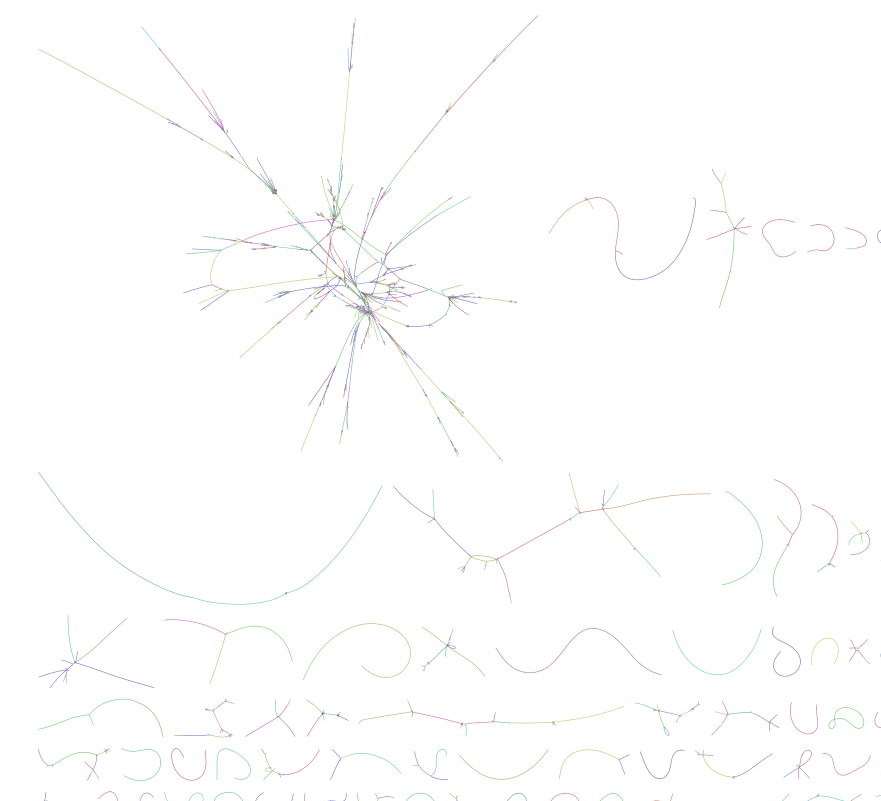

___